<h1 style="text-align:center; color:green; font-size:48px;">
Step 1: Base Heating Network
</h1>

#### Install libraries (if you did not do it before on the terminal)

In [95]:
# !pip install numpy==2.0.2 pandas==2.3.1
# !pip install matplotlib
# !pip install git+https://github.com/oemof/dhnx.git@dev
# !pip install osmnx==1.9.4 oemof.solph==0.5.6

# Import libraries

In [96]:
import matplotlib.pyplot as plt
import dhnx
import pandas as pd
import oemof.solph
from pyomo.environ import SolverFactory


## 1.1 Create network and plot

In [97]:
# Initialize thermal network
network = dhnx.network.ThermalNetwork()

# Load town parameter
network = network.from_csv_folder(r"DHNx_files/Step_1/twn_data")

# Load investment parameter
invest_opt = dhnx.input_output.load_invest_options(r"DHNx_files/Step_1/invest_data")

In [98]:
print(network)

dhnx.network.ThermalNetwork object with these components
 * 2 producers
 * 5 consumers
 * 27 forks
 * 37 pipes



In [100]:
# --- Project lon/lat -> meters (UTM 35N) for plotting only ---
import copy
from pyproj import Transformer

# transformer: WGS84 (EPSG:4326) -> UTM zone 35N (EPSG:32635)
tf = Transformer.from_crs("EPSG:4326", "EPSG:32635", always_xy=True)

def project_df_lonlat(df):
    d = df.copy()
    x, y = tf.transform(d['lon'].to_numpy(), d['lat'].to_numpy())
    d['lon'] = x  # overwrite columns that StaticMap expects
    d['lat'] = y
    return d

# Make a plotting-only copy of the network
net_plot = copy.deepcopy(network)

# Project the component coordinate tables used in your plot
net_plot.components.consumers = project_df_lonlat(network.components.consumers)
net_plot.components.producers = project_df_lonlat(network.components.producers)
net_plot.components.forks     = project_df_lonlat(network.components.forks)


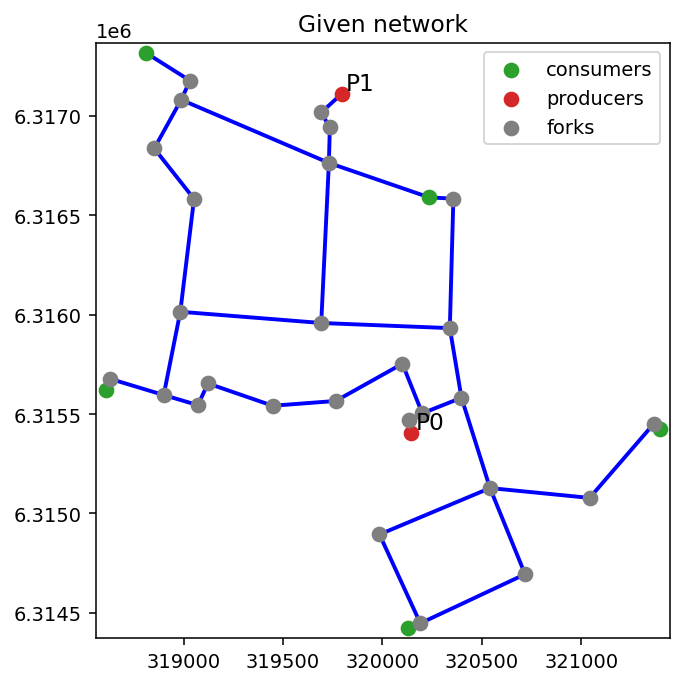

In [101]:
# plot initial/given network
static_map = dhnx.plotting.StaticMap(net_plot) # That's how DHNx plots the network
static_map.draw(background_map=False) # This line to show the network on a blank area.
ax = plt.gca()

plt.title('Given network') 

#Scatter plots to differentiate the consumers, producers and forks. 
ax.scatter(net_plot.components.consumers['lon'], net_plot.components.consumers['lat'],
           color='tab:green', label='consumers', zorder=2.5, s=50)
ax.scatter(net_plot.components.producers['lon'], net_plot.components.producers['lat'],
           color='tab:red', label='producers', zorder=2.5, s=50)
ax.scatter(net_plot.components.forks['lon'], net_plot.components.forks['lat'],
           color='tab:grey', label='forks', zorder=2.5, s=50)

# Label producers near their actual locations (remove your old plt.text(-2, 32, ...) lines)
if len(net_plot.components.producers) >= 1:
    p0 = net_plot.components.producers.iloc[0]
    ax.text(p0['lon'] + 20, p0['lat'] + 20, 'P0', fontsize=12)  # ~20 m offset
if len(net_plot.components.producers) >= 2:
    p1 = net_plot.components.producers.iloc[1]
    ax.text(p1['lon'] + 20, p1['lat'] + 20, 'P1', fontsize=12)

#  Clamp the axis limits around your data so nothing explodes the canvas
all_x = pd.concat([
    net_plot.components.consumers['lon'],
    net_plot.components.producers['lon'],
    net_plot.components.forks['lon'],
])
all_y = pd.concat([
    net_plot.components.consumers['lat'],
    net_plot.components.producers['lat'],
    net_plot.components.forks['lat'],
])
pad = 50  # meters of padding around the outer points
ax.set_xlim(all_x.min() - pad, all_x.max() + pad)
ax.set_ylim(all_y.min() - pad, all_y.max() + pad)

ax.set_aspect('equal', adjustable='box')
ax.legend()
plt.tight_layout()
plt.show()

## 1.2 Investment optimization of the network

In [87]:
# Optimize the investment data
network.optimize_investment(invest_options=invest_opt,  solver='cbc')


INFO:dhnx.optimization.optimization_models:Initialize the energy system
INFO:dhnx.optimization.optimization_models:Create oemof objects


INFO:dhnx.optimization.optimization_models:Producers, Consumers Nodes appended.
c:\Users\irfan\anaconda3\envs\env_P2\lib\site-packages\oemof\solph\flows\_flow.py:163: FutureWarning: For backward compatibility, the option investment overwrites the option nominal_value. Both options cannot be set at the same time.
  warn(msg, FutureWarning)
c:\Users\irfan\anaconda3\envs\env_P2\lib\site-packages\oemof\network\network\nodes.py:250: FutureWarning: Usage of oemof.network.Component is deprecated. Use oemof.network.Node instead.
  warnings.warn(
INFO:dhnx.optimization.optimization_models:DHS Nodes appended.
INFO:dhnx.optimization.optimization_models:Energysystem has been created
INFO:dhnx.optimization.optimization_models:Build the operational model
INFO:dhnx.optimization.optimization_models:Solve the optimization problem


Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Jul 31 2025 

command line - C:\Users\irfan\anaconda3\envs\env_P2\Library\bin\cbc.exe -printingOptions all -import C:\Users\irfan\AppData\Local\Temp\tmpbgh6gnsx.pyomo.lp -stat=1 -solve -solu C:\Users\irfan\AppData\Local\Temp\tmpbgh6gnsx.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 424 (-798) rows, 392 (-666) columns and 1424 (-1350) elements
Statistics for presolved model
Original problem has 132 integers (132 of which binary)
Presolved problem has 132 integers (132 of which binary)
==== 128 zero objective 149 different
==== absolute objective values 149 different
==== for integers 0 zero objective 74 different
==== for integers absolute objective values 74 different
===== end objective counts


Problem has 424 rows, 392 columns (264 with objective) and 1424 elements
Column breakdown:
256 of type 0.0->inf, 4 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type fre

INFO:root:Optimization successful...


## 1.3 Results postprocessing and Plotting 


In [88]:
# ####### Postprocessing and Plotting ###########
results_edges = network.results.optimization['components']['pipes']
print(results_edges[['from_node', 'to_node', 'hp_type', 'capacity',
                     'direction', 'costs', 'losses']])

results_edges.to_csv("DHNx_files/Step_1/Outputs/Optimum_network_base.csv", index=True)

print('Objective value: ', network.results.optimization['oemof_meta']['objective'])

# assign new ThermalNetwork with invested pipes
twn_results = network
twn_results.components['pipes'] = results_edges[results_edges['capacity'] > 0.001]



      from_node      to_node hp_type    capacity  direction         costs  \
id                                                                          
0   producers-0     forks-17   DN-50  4813.77080          1  3.067222e+06   
1      forks-17     forks-16   DN-50  4802.26880          1  3.402821e+06   
2      forks-16     forks-18   DN-50  3218.41120          1  7.139526e+06   
3      forks-18     forks-19   DN-50  3191.63790          1  1.597184e+07   
4      forks-19     forks-20   DN-50  2985.40310          1  1.599882e+07   
5      forks-20     forks-21   DN-50  2925.40750          1  1.547280e+07   
6      forks-21  consumers-3   DN-50  2867.38450          1  4.963587e+07   
7      forks-16     forks-15   DN-50  1571.09700          1  5.522356e+06   
8      forks-15     forks-14   DN-50  1550.38820          1  7.809660e+06   
9      forks-14     forks-13   DN-50  1521.10200          1  6.396968e+06   
10     forks-13     forks-12   DN-50  1497.11330          1  6.859846e+06   

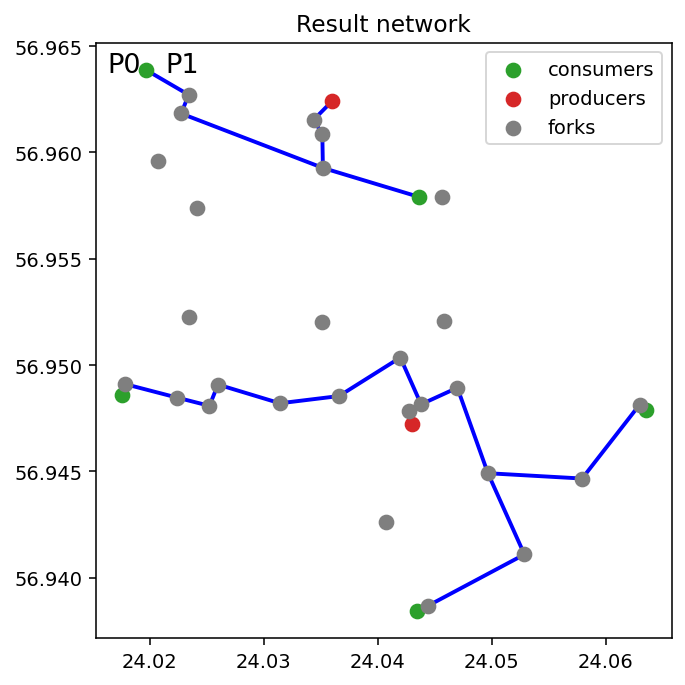

In [89]:
# plot invested edges
plt.rcParams['figure.figsize'] = (10, 8)   # <-- bigger
plt.rcParams['figure.dpi'] = 140

static_map_2 = dhnx.plotting.StaticMap(twn_results)
static_map_2.draw(background_map=False)
ax = plt.gca()
ax.set_title('Result network')

# Scatter points
plt.scatter(network.components.consumers['lon'], network.components.consumers['lat'],
            color='tab:green', label='consumers', zorder=2.5, s=50)
plt.scatter(network.components.producers['lon'], network.components.producers['lat'],
            color='tab:red', label='producers', zorder=2.5, s=50)
plt.scatter(network.components.forks['lon'], network.components.forks['lat'],
            color='tab:grey', label='forks', zorder=2.5, s=50)

# labels that DON'T expand the axis extent
plt.text(0.02, 0.95, 'P0', transform=ax.transAxes, fontsize=14)
plt.text(0.12, 0.95, 'P1', transform=ax.transAxes, fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()